In [3]:
!rm -rf ~/.local/share/weaviate

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
from random import random, randint
from math import floor, log
import networkx as nx
import numpy as np
import matplotlib as mtplt
from matplotlib import pyplot as plt


vec_num = 40 # Number of vectors (nodes)
dim = 2 ## Dimention. Set to be 2. All the graph plots are for dim 2. If changed, then plots should be commented. 
m_nearest_neighbor = 2 # M Nearest Neigbor used in construction of the Navigable Small World (NSW)

vec_pos = np.random.uniform(size=(vec_num, dim))

### Query Vector


In [3]:
## Query
query_vec = [0.5, 0.5]

nodes = []
nodes.append(("Q",{"pos": query_vec}))

G_query = nx.Graph()
G_query.add_nodes_from(nodes)

print("nodes = ", nodes, flush=True)

pos_query=nx.get_node_attributes(G_query,'pos')

nodes =  [('Q', {'pos': [0.5, 0.5]})]


In [17]:
def nearest_neighbor(vec_pos, query_vec):
    # Initialize the graphs
    G_lin = nx.Graph()
    G_best = nx.Graph()
    
    # Assuming vec_pos is a 2D numpy array where each row is a node's position vector
    num_nodes = vec_pos.shape[0]
    nearest_node = None
    min_dist = np.inf
    
    # Add nodes to G_lin with positions and find the nearest node
    for node in range(num_nodes):
        pos = vec_pos[node, :]
        G_lin.add_node(node, pos=pos)
        dist = np.linalg.norm(pos - query_vec)
        if dist < min_dist:
            min_dist = dist
            nearest_node = node
    
    # Add the nearest node to G_best
    if nearest_node is not None:
        G_best.add_node(nearest_node, pos=vec_pos[nearest_node, :])
    
    return G_lin, G_best

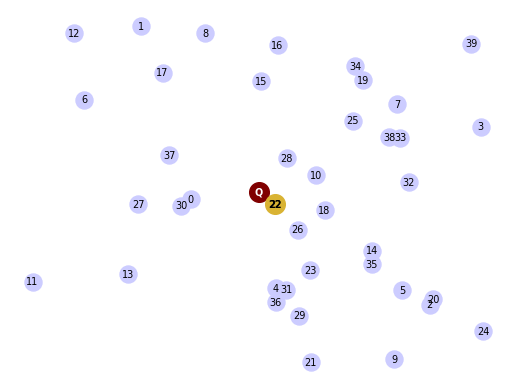

In [18]:
(G_lin, G_best) = nearest_neighbor(vec_pos,query_vec)

pos_lin=nx.get_node_attributes(G_lin,'pos')
pos_best=nx.get_node_attributes(G_best,'pos')

fig, axs = plt.subplots()

nx.draw(G_lin, pos_lin, with_labels=True, node_size=150, node_color=[[0.8,0.8,1]], width=0.0, font_size=7, ax = axs)
nx.draw(G_query, pos_query, with_labels=True, node_size=200, node_color=[[0.5,0,0]], font_color='white', width=0.5, font_size=7, font_weight='bold', ax = axs)
nx.draw(G_best, pos_best, with_labels=True, node_size=200, node_color=[[0.85,0.7,0.2]], width=0.5, font_size=7, font_weight='bold', ax = axs)

In [33]:
from sklearn.neighbors import NearestNeighbors

def construct_HNSW(vec_pos, m_nearest_neighbor):
    # Initialize the list of graphs
    GraphArray = []
    
    # Create the base layer graph
    G = nx.Graph()
    for i, pos in enumerate(vec_pos):
        G.add_node(i, pos=pos)
    GraphArray.append(G)
    
    # Create the other layers
    for layer in range(1, m_nearest_neighbor):
        # Create a new graph for this layer
        G = nx.Graph()
        
        # Add a subset of the nodes from the previous layer to this layer
        nodes = list(GraphArray[layer - 1].nodes)
        subset_nodes = nodes[::2**layer]  # Take every 2^layer-th node
        for node in subset_nodes:
            G.add_node(node, pos=GraphArray[layer - 1].nodes[node]['pos'])
        
        # Add edges between each node and its m nearest neighbors
        nbrs = NearestNeighbors(n_neighbors=m_nearest_neighbor, algorithm='ball_tree').fit(vec_pos)
        distances, indices = nbrs.kneighbors(vec_pos)
        for i, node in enumerate(G.nodes):
            for j in indices[i]:
                if j in G.nodes:
                    G.add_edge(node, j)
        
        GraphArray.append(G)
    
    return GraphArray

layer_i =  1


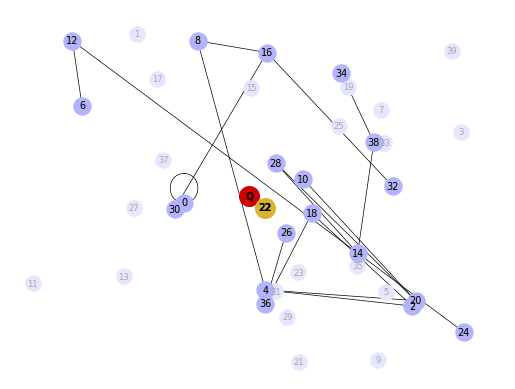

layer_i =  0


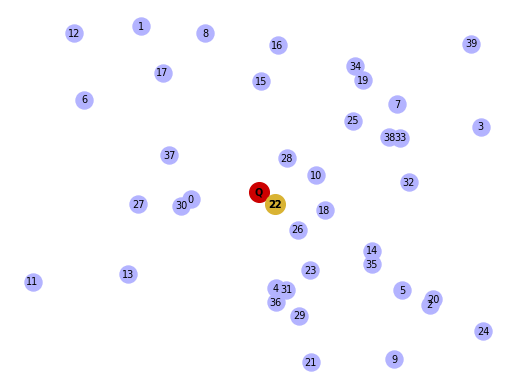

In [34]:
GraphArray = construct_HNSW(vec_pos,m_nearest_neighbor)

for layer_i in range(len(GraphArray)-1,-1,-1):
    fig, axs = plt.subplots()

    print("layer_i = ", layer_i)
        
    if layer_i>0:
        pos_layer_0 = nx.get_node_attributes(GraphArray[0],'pos')
        nx.draw(GraphArray[0], pos_layer_0, with_labels=True, node_size=120, node_color=[[0.9,0.9,1]], width=0.0, font_size=6, font_color=(0.65,0.65,0.65), ax = axs)

    pos_layer_i = nx.get_node_attributes(GraphArray[layer_i],'pos')
    nx.draw(GraphArray[layer_i], pos_layer_i, with_labels=True, node_size=150, node_color=[[0.7,0.7,1]], width=0.5, font_size=7, ax = axs)
    nx.draw(G_query, pos_query, with_labels=True, node_size=200, node_color=[[0.8,0,0]], width=0.5, font_size=7, font_weight='bold', ax = axs)
    nx.draw(G_best, pos_best, with_labels=True, node_size=200, node_color=[[0.85,0.7,0.2]], width=0.5, font_size=7, font_weight='bold', ax = axs)
    plt.show()